In [1]:
import numpy as np
#np.bool = np.bool_
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
from datetime import date, timedelta, datetime
import cartopy.crs as ccrs
import warnings
from mpl_toolkits.basemap import Basemap
warnings.filterwarnings('ignore')
from urllib.parse import quote
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#### Data is 1 week: 06-30-2023 -> 07-06-2023

In [60]:
satellite = pd.read_csv('chl.csv')
units_s = satellite.iloc[0].to_numpy()
satellite = satellite.drop(index = 0)
satellite['chlor_a'] = pd.to_numeric(satellite['chlor_a'], errors='coerce')
satellite['latitude'] = pd.to_numeric(satellite['latitude'], errors='coerce')
satellite['longitude'] = pd.to_numeric(satellite['longitude'], errors='coerce')
satellite = satellite[(satellite.get('chlor_a') >= 0) | (satellite.get('chlor_a') < 0)]

In [75]:
satellite

,time,latitude,longitude,chlor_a
1538,2023-06-30T00:00:00Z,35.145833,-120.770833,9.739783
1539,2023-06-30T00:00:00Z,35.145833,-120.729167,9.559745
1902,2023-06-30T00:00:00Z,35.062500,-120.687500,8.422530
1903,2023-06-30T00:00:00Z,35.062500,-120.645833,8.422530
8484,2023-06-30T00:00:00Z,33.562500,-117.937500,0.572345
...,...,...,...,...
122899,2023-07-07T00:00:00Z,32.020833,-116.979167,0.498706
123077,2023-07-07T00:00:00Z,31.979167,-117.104167,0.157303
123078,2023-07-07T00:00:00Z,31.979167,-117.062500,0.206571
123079,2023-07-07T00:00:00Z,31.979167,-117.020833,0.341920


#### Line 90 didn't have chl data for the time period I looked at so I switched to 80

In [64]:
glider = pd.read_csv('line80.csv')
units_g = glider.iloc[0].to_numpy()
glider = glider.drop(index = 0)
glider = glider[glider.get('depth') == '10.0']
glider['depth'] = pd.to_numeric(glider['depth'], errors='coerce')
glider['chlorophyll'] = pd.to_numeric(glider['chlorophyll'], errors='coerce')
glider['latitude'] = pd.to_numeric(glider['latitude'], errors='coerce')
glider['longitude'] = pd.to_numeric(glider['longitude'], errors='coerce')
glider['profile'] = pd.to_numeric(glider['profile'], errors='coerce')
glider = glider[(glider.get('chlorophyll') >= 0) | (glider.get('chlorophyll') < 0)]

In [ ]:
print('latitude range', round(glider.latitude.min(), 2), round(glider.latitude.max(), 2))
print('longitude range', round(glider.longitude.min(), 2), round(glider.longitude.max(), 2))

In [76]:
glider

,profile,depth,time,latitude,longitude,chlorophyll
1,55817.0,10.0,2023-06-30T00:52:25Z,34.257207,-120.555730,1.642615
2,55818.0,10.0,2023-06-30T03:58:54Z,34.250090,-120.537525,1.563600
3,55819.0,10.0,2023-06-30T07:00:14Z,34.248537,-120.516155,1.898000
4,55820.0,10.0,2023-06-30T09:56:10Z,34.247850,-120.487242,1.721250
5,55821.0,10.0,2023-06-30T12:45:24Z,34.246130,-120.458277,1.534091
...,...,...,...,...,...,...
57,55873.0,10.0,2023-07-06T11:53:22Z,34.298390,-119.810950,5.600700
58,55874.0,10.0,2023-07-06T13:13:35Z,34.298135,-119.805110,7.379100
59,55875.0,10.0,2023-07-06T14:12:05Z,34.298100,-119.799685,6.933667
60,55876.0,10.0,2023-07-06T15:03:00Z,34.298070,-119.794140,7.378333


#### Plot glider track

In [ ]:
plt.figure(figsize=(14, 10))
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([239, 241, 33, 35], ccrs.PlateCarree())
ax1.set_xticks(range(240, 241, 1), crs=ccrs.PlateCarree())
ax1.set_yticks(range(33, 35, 1), crs=ccrs.PlateCarree())

# add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# bring the lon and lat data into a numpy array 
x, y = glider.longitude.to_numpy(), glider.latitude.to_numpy()

ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=ccrs.PlateCarree(),
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=ccrs.PlateCarree(),
               markersize=10)
plt.title('Glider Line #80\nPoint Conception, CA', fontsize=20)

plt.show()

In [ ]:
glider['date'] = glider['datetime'].dt.date
glider['time'] = glider['datetime'].dt.time
glider[['longitude_str', 'latitude_str', 'date_str']] = glider[['longitude', 'latitude', 'date']].to_numpy(dtype=str)

#### Request best spatial + temporal matchups

In [ ]:
col_names = ["iso_date", "matched_lat", "matched_lon", "matched_chla"]
tot = pd.DataFrame(columns=col_names)

# create variables for the unchanging parts of the ERDDAP data-request URL. 
base_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/'
dataset_id = "pmlEsaCCI60OceanColorDaily"
file_type = '.csv'
query_start = '?'
erddap_variable = 'chlor_a'

# create the start of the ERDDAP data-request URL by joining URL components
start_url = ''.join([base_url,
                     dataset_id,
                     file_type,
                     query_start,
                     erddap_variable
                     ])

# Finish each URL and download
for i in range(0, len(glider)):
    # for each row in the track data frame, create the query part of the ERDDAP data-request URL.
    query_url = ''.join([
                         '[(' + glider['date_str'].to_numpy()[i] + '):1:(' + glider['date_str'].to_numpy()[i] + ')]',
                         '[(' + glider['latitude_str'].to_numpy()[i] + '):1:(' + glider['latitude_str'].to_numpy()[i] + ')]', 
                         '[(' + glider['longitude_str'].to_numpy()[i] + '):1:(' + glider['longitude_str'].to_numpy()[i] + ')]'
                         ])
    encoded_query = quote(query_url, safe='')

    # join the start and query parts of the url
    url = start_url + encoded_query
    print(i+1, 'of', len(glider), url)

    # download the data as a CSV file directly into Pandas
    new = pd.read_csv(url, skiprows=1)
    new.columns = col_names
    
    # load into the holding data frame
    tot = pd.concat([tot, new], ignore_index=True)

#### No non-NaN chl values in matchups

In [ ]:
tot[(tot.get('matched_chla') >= 0) | (tot.get('matched_chla') < 0)]

#### Very close matchups

In [ ]:
glider[['matched_lat', 'matched_lon', 'matched_chla', 'matched_time']] = tot[['matched_lat',
                                                          'matched_lon',
                                                          'matched_chla', 'iso_date'
                                                          ]]

#### Plot all satellite values during the entire week

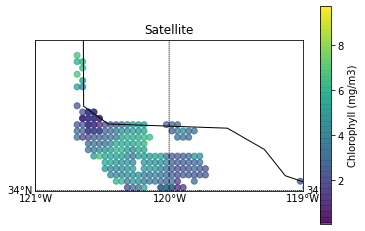

In [91]:
#latitude range 34.18 34.3
#longitude range -120.56 -119.79
m = Basemap(projection='mill',
            llcrnrlat = 34,
            llcrnrlon = -121,
            urcrnrlat = 35,
            urcrnrlon = -119,
            resolution='l')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='black')
m.drawparallels(np.arange(10,40,1),labels=[1,1,0,0])
m.drawmeridians(np.arange(230,260,1),labels=[0,0,0,1])
x, y = m(satellite['longitude'].values, satellite['latitude'].values)
m.scatter(x, y, c=satellite['chlor_a'].values, cmap='viridis', marker='o', alpha=0.7)
plt.colorbar(label='Chlorophyll (mg/m3)')
plt.title('Satellite')#filename+"\nChange in ppt over 30yrs\n+0.33mm/day")
plt.show()

#### Quick comparison of satellite and glider -- glider seems to have higher values?

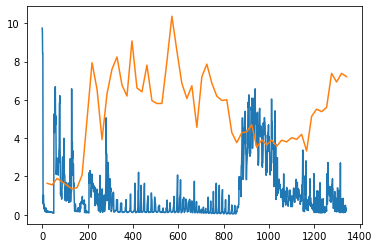

In [99]:
satellite = satellite.reset_index()
plt.plot(satellite.index,satellite['chlor_a'])
plt.plot(glider.index*(1342/61),glider['chlorophyll'])

#### 61/61 matchups and very close spatially

In [ ]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
#ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([239, 241, 33, 35], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(240, 241, 1), crs=ccrs.PlateCarree())
ax1.set_yticks(range(33, 35, 1), crs=ccrs.PlateCarree())

# add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6',label='_nolegend_')
ax1.coastlines()
# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# bring the lon and lat data into a numpy array 
x, y = glider.longitude.to_numpy(), glider.latitude.to_numpy()

#ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=ccrs.PlateCarree(),
               markersize=12,label='_nolegend_')
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=ccrs.PlateCarree(),
               markersize=12,label='_nolegend_')
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  color = 'k'
                  )
x2,y2 = glider.matched_lon.to_numpy(), glider.matched_lat.to_numpy()
ax1 = plt.scatter(x2, y2, transform=ccrs.PlateCarree(),
                  marker='o',
                  color = 'b'
                  )
plt.title('Satellite Matchups\nPoint Conception, CA', fontsize=20)
plt.legend(['Land','Ocean','Glider','Satellite'])
plt.show()